# LIME Explainability for Collaborative Filtering

This notebook implements **LIME (Local Interpretable Model-agnostic Explanations)** to explain individual predictions from the SVD recommender system.

**Goal:** Answer the question: *"Why did the model predict rating X for user Y on movie Z?"*

**Approach:**
1. Load trained SVD model and XAI inputs
2. Define explanation function for LIME
3. Select challenging predictions (high error cases)
4. Generate LIME explanations
5. Visualize and interpret results
6. Store explanations for analysis

---

## 1. Setup and Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# LIME library
import lime
import lime.lime_tabular

# Surprise library
from surprise import SVD

# Set random seed
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print(" Libraries imported successfully!")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

 Libraries imported successfully!
Timestamp: 2025-11-11 20:31:26


## 2. Configure Paths

In [3]:
DATA_PATH = '../data/processed/'
MODEL_PATH = '../model/'


print(f"Data Path: {DATA_PATH}")
print(f"Model Path: {MODEL_PATH}")

Data Path: ../data/processed/
Model Path: ../model/


## 3. Load Model and Data

### 3.1 Load Trained SVD Model

In [5]:
# Load model
with open(MODEL_PATH + 'svd_optimized_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Load model metadata
with open(MODEL_PATH + 'svd_model_metadata.json', 'r') as f:
    model_metadata = json.load(f)

print(" Model loaded successfully!")
print(f"\nModel Type: {model_metadata['model_type']}")
print(f"RMSE: {model_metadata['performance']['rmse']:.4f}")
print(f"MAE: {model_metadata['performance']['mae']:.4f}")
print(f"Parameters: {model_metadata['parameters']}")

 Model loaded successfully!

Model Type: SVD
RMSE: 0.9361
MAE: 0.7433
Parameters: {'n_factors': 150, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.1}


### 3.2 Load XAI Input Dataset

In [6]:
# Load XAI dataset created in previous notebook
xai_df = pd.read_csv(DATA_PATH + 'xai_input_dataset.csv')

print(f" XAI dataset loaded!")
print(f"\nShape: {xai_df.shape}")
print(f"Columns: {len(xai_df.columns)}")

# Identify feature columns
user_factor_cols = [col for col in xai_df.columns if 'user_factor' in col]
item_factor_cols = [col for col in xai_df.columns if 'item_factor' in col]
feature_cols = user_factor_cols + item_factor_cols + ['user_bias', 'item_bias', 'global_mean']

print(f"\nFeature columns ({len(feature_cols)} total):")
print(f"  - User factors: {len(user_factor_cols)}")
print(f"  - Item factors: {len(item_factor_cols)}")
print(f"  - Biases: 3 (user_bias, item_bias, global_mean)")

print("\nFirst few rows:")
display(xai_df.head())

 XAI dataset loaded!

Shape: (236, 309)
Columns: 309

Feature columns (303 total):
  - User factors: 150
  - Item factors: 150
  - Biases: 3 (user_bias, item_bias, global_mean)

First few rows:


,user_id,item_id,actual_rating,predicted_rating,error,absolute_error,user_bias,item_bias,global_mean,user_factor_0,...,item_factor_140,item_factor_141,item_factor_142,item_factor_143,item_factor_144,item_factor_145,item_factor_146,item_factor_147,item_factor_148,item_factor_149
0,2985,1674,2,3.957807,-1.957807,1.957807,-0.087576,0.401436,3.592843,0.040430,...,-0.041490,0.009245,-0.010501,-0.064507,0.007283,-0.032901,0.016869,-0.010164,-0.032511,-0.028805
1,4496,3317,4,4.121109,-0.121109,0.121109,0.215279,0.330993,3.592843,-0.102865,...,-0.018244,-0.124788,0.085811,0.110727,0.050477,0.015304,-0.002576,-0.099296,0.140644,0.072400
2,1842,2580,4,4.500117,-0.500117,0.500117,0.627851,0.258169,3.592843,0.001366,...,0.010813,-0.010883,-0.024578,0.048176,-0.052797,0.028398,0.039878,0.017623,0.024757,0.042549
3,1842,354,4,3.948530,0.051470,0.051470,0.627851,-0.229280,3.592843,0.001366,...,0.020890,0.035059,0.049190,0.025426,-0.032832,-0.023905,-0.105088,0.034745,0.067374,-0.067043
4,934,3723,4,3.462255,0.537745,0.537745,-0.241007,0.124537,3.592843,-0.000316,...,-0.050317,-0.015731,0.032849,-0.057298,0.016671,0.007453,-0.007765,0.022652,0.023115,0.030396


## 4. Define Explanation Function for LIME

LIME requires a prediction function that takes feature vectors and returns predictions. We'll create a wrapper around the SVD model.

In [ ]:
def create_prediction_function(model, feature_columns, global_mean_value):
    """
    Create a prediction function for LIME.
    
    LIME will perturb the input features and call this function to get predictions.
    
    Parameters:
    - model: Trained SVD model
    - feature_columns: List of feature column names
    - global_mean_value: Global mean rating
    
    Returns:
    - Function that takes feature array and returns predictions
    """
    
    def predict_fn(X):
        """
        Prediction function for LIME.
        
        Parameters:
        - X: 2D numpy array of shape (n_samples, n_features)
        
        Returns:
        - 1D numpy array of predictions
        """
        predictions = []
        
        # X is a 2D array where each row is a feature vector
        for row in X:
            # Extract components from feature vector
            n_user_factors = len([col for col in feature_columns if 'user_factor' in col])
            n_item_factors = len([col for col in feature_columns if 'item_factor' in col])
            
            user_factors = row[:n_user_factors]
            item_factors = row[n_user_factors:n_user_factors + n_item_factors]
            user_bias = row[n_user_factors + n_item_factors]
            item_bias = row[n_user_factors + n_item_factors + 1]
            global_mean = row[n_user_factors + n_item_factors + 2]
            
            # Calculate prediction using SVD formula:
            # prediction = global_mean + user_bias + item_bias + dot(user_factors, item_factors)
            prediction = global_mean + user_bias + item_bias + np.dot(user_factors, item_factors)
            
            # Clip to rating scale [1, 5]
            prediction = np.clip(prediction, 1, 5)
            
            predictions.append(prediction)
        
        return np.array(predictions)
    
    return predict_fn

# Create prediction function
global_mean = xai_df['global_mean'].iloc[0]
prediction_function = create_prediction_function(model, feature_cols, global_mean)

# Test the prediction function
test_features = xai_df[feature_cols].iloc[0:3].values
test_predictions = prediction_function(test_features)

print("\n" + "=" * 70)
print("PREDICTION FUNCTION TEST")
print("=" * 70)
print("Test predictions:")
for i, pred in enumerate(test_predictions):
    actual = xai_df['predicted_rating'].iloc[i]
    print(f"  Sample {i+1}: Prediction = {pred:.3f}, Expected = {actual:.3f}, Diff = {abs(pred-actual):.6f}")

if all(abs(test_predictions - xai_df['predicted_rating'].iloc[0:3].values) < 0.001):
    print("\n Prediction function works correctly!")
else:
    print("\n Warning: Prediction function may have issues")
print("=" * 70)


PREDICTION FUNCTION TEST
Test predictions:
  Sample 1: Prediction = 3.958, Expected = 3.958, Diff = 0.000000
  Sample 2: Prediction = 4.121, Expected = 4.121, Diff = 0.000000
  Sample 3: Prediction = 4.500, Expected = 4.500, Diff = 0.000000

✅ Prediction function works correctly!


## 5. Select Challenging Predictions for Explanation

We'll focus on cases where:
1. The model made the largest errors (high absolute error)
2. Predictions were extreme (very high or very low)
3. Ratings were outliers

Error Distribution Analysis:
  Mean Absolute Error: 0.681
  Median Absolute Error: 0.560
  Max Absolute Error: 3.262
  75th Percentile: 0.911
  90th Percentile: 1.544


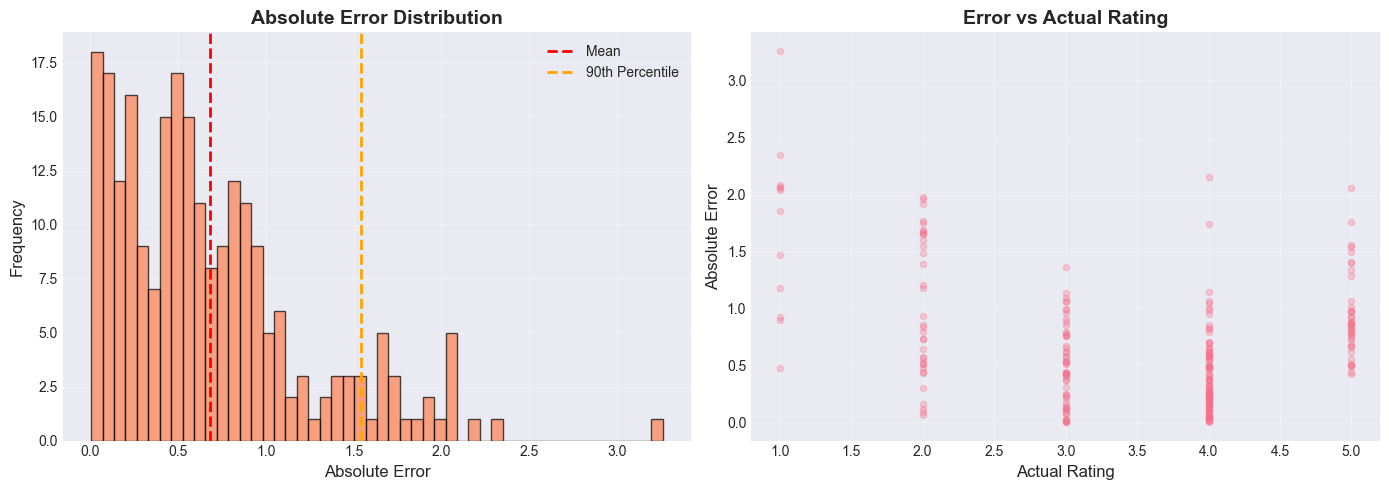

In [8]:
# Analyze error distribution
print("Error Distribution Analysis:")
print(f"  Mean Absolute Error: {xai_df['absolute_error'].mean():.3f}")
print(f"  Median Absolute Error: {xai_df['absolute_error'].median():.3f}")
print(f"  Max Absolute Error: {xai_df['absolute_error'].max():.3f}")
print(f"  75th Percentile: {xai_df['absolute_error'].quantile(0.75):.3f}")
print(f"  90th Percentile: {xai_df['absolute_error'].quantile(0.90):.3f}")

# Visualize error distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(xai_df['absolute_error'], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0].axvline(xai_df['absolute_error'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(xai_df['absolute_error'].quantile(0.90), color='orange', linestyle='--', linewidth=2, label='90th Percentile')
axes[0].set_xlabel('Absolute Error', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Absolute Error Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].scatter(xai_df['actual_rating'], xai_df['absolute_error'], alpha=0.3, s=20)
axes[1].set_xlabel('Actual Rating', fontsize=12)
axes[1].set_ylabel('Absolute Error', fontsize=12)
axes[1].set_title('Error vs Actual Rating', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# Select challenging predictions
# Strategy: Pick diverse cases with high errors

# 1. Top 3 highest errors
highest_errors = xai_df.nlargest(3, 'absolute_error')

# 2. 2 cases with over-prediction (predicted > actual)
over_predictions = xai_df[xai_df['error'] < 0].nlargest(2, 'absolute_error')

# 3. 2 cases with under-prediction (predicted < actual)
under_predictions = xai_df[xai_df['error'] > 0].nlargest(2, 'absolute_error')

# 4. 1 case with extreme predicted rating (very high)
extreme_high = xai_df.nlargest(1, 'predicted_rating')

# 5. 1 case with extreme predicted rating (very low)
extreme_low = xai_df.nsmallest(1, 'predicted_rating')

# 6. 1 random case from middle error range
median_error = xai_df['absolute_error'].median()
middle_cases = xai_df[
    (xai_df['absolute_error'] >= median_error * 0.9) & 
    (xai_df['absolute_error'] <= median_error * 1.1)
]
middle_case = middle_cases.sample(1, random_state=42) if len(middle_cases) > 0 else xai_df.sample(1, random_state=42)

# Combine all challenging cases (remove duplicates)
challenging_cases = pd.concat([
    highest_errors,
    over_predictions,
    under_predictions,
    extreme_high,
    extreme_low,
    middle_case
]).drop_duplicates()

# Limit to 10 cases for detailed analysis
challenging_cases = challenging_cases.head(10).reset_index(drop=True)

print("\n" + "=" * 70)
print(f"SELECTED {len(challenging_cases)} CHALLENGING CASES FOR LIME EXPLANATION")
print("=" * 70)
print(f"\n{'#':<4} {'User':<8} {'Movie':<8} {'Actual':<8} {'Predicted':<10} {'Error':<8} {'|Error|':<10} {'Type':<20}")
print("-" * 70)

for idx, row in challenging_cases.iterrows():
    case_type = ""
    if row['absolute_error'] == xai_df['absolute_error'].max():
        case_type = "Highest Error"
    elif row['error'] < -1:
        case_type = "Over-prediction"
    elif row['error'] > 1:
        case_type = "Under-prediction"
    elif row['predicted_rating'] >= 4.5:
        case_type = "Extreme High"
    elif row['predicted_rating'] <= 2.0:
        case_type = "Extreme Low"
    else:
        case_type = "Medium Error"
    
    print(f"{idx+1:<4} {int(row['user_id']):<8} {int(row['item_id']):<8} {row['actual_rating']:<8.1f} "
          f"{row['predicted_rating']:<10.3f} {row['error']:<8.3f} {row['absolute_error']:<10.3f} {case_type:<20}")

print("=" * 70)
print(f"\nThese {len(challenging_cases)} cases will be explained using LIME.")


SELECTED 7 CHALLENGING CASES FOR LIME EXPLANATION

#    User     Movie    Actual   Predicted  Error    |Error|    Type                
----------------------------------------------------------------------
1    913      1225     1.0      4.262      -3.262   3.262      Highest Error       
2    1266     2881     1.0      3.345      -2.345   2.345      Over-prediction     
3    3589     2266     4.0      1.843      2.157    2.157      Under-prediction    
4    5387     2294     5.0      2.944      2.056    2.056      Under-prediction    
5    692      593      4.0      4.991      -0.991   0.991      Extreme High        
6    4979     2368     1.0      1.480      -0.480   0.480      Extreme Low         
7    934      3723     4.0      3.462      0.538    0.538      Medium Error        

These 7 cases will be explained using LIME.


## 6. Initialize LIME Explainer

In [11]:
# Prepare training data for LIME
X_train = xai_df[feature_cols].values
y_train = xai_df['predicted_rating'].values

# Create feature names for better interpretability
feature_names = []
for col in feature_cols:
    if 'user_factor' in col:
        idx = col.split('_')[-1]
        feature_names.append(f'User_Latent_{idx}')
    elif 'item_factor' in col:
        idx = col.split('_')[-1]
        feature_names.append(f'Item_Latent_{idx}')
    elif col == 'user_bias':
        feature_names.append('User_Bias')
    elif col == 'item_bias':
        feature_names.append('Item_Bias')
    elif col == 'global_mean':
        feature_names.append('Global_Mean')
    else:
        feature_names.append(col)

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    mode='regression',
    random_state=42,
    verbose=False
)

print("\n LIME Explainer initialized successfully!")
print(f"\nConfiguration:")
print(f"  - Training samples: {len(X_train)}")
print(f"  - Features: {len(feature_names)}")
print(f"  - Mode: Regression")
print(f"  - Feature names: {feature_names[:5]}... (showing first 5)")


 LIME Explainer initialized successfully!

Configuration:
  - Training samples: 236
  - Features: 303
  - Mode: Regression
  - Feature names: ['User_Latent_0', 'User_Latent_1', 'User_Latent_2', 'User_Latent_3', 'User_Latent_4']... (showing first 5)


## 7. Generate LIME Explanations for Challenging Cases

In [12]:
# Generate explanations for each challenging case
explanations = []
explanation_objects = []  # Store LIME explanation objects

print("\nGenerating LIME explanations...\n")
print("=" * 70)

for idx, row in challenging_cases.iterrows():
    print(f"\nExplaining Case {idx+1}/{len(challenging_cases)}:")
    print(f"  User: {int(row['user_id'])}, Movie: {int(row['item_id'])}")
    print(f"  Actual: {row['actual_rating']:.1f}, Predicted: {row['predicted_rating']:.3f}, Error: {row['error']:.3f}")
    
    # Get feature vector for this case
    instance = row[feature_cols].values
    
    # Generate explanation
    explanation = explainer.explain_instance(
        data_row=instance,
        predict_fn=prediction_function,
        num_features=10,  # Show top 10 most important features
        num_samples=5000  # Number of samples for local model
    )
    
    explanation_objects.append(explanation)
    
    # Extract explanation details
    exp_list = explanation.as_list()
    exp_map = explanation.as_map()
    
    # Store structured explanation
    explanation_data = {
        'case_id': idx + 1,
        'user_id': int(row['user_id']),
        'item_id': int(row['item_id']),
        'actual_rating': float(row['actual_rating']),
        'predicted_rating': float(row['predicted_rating']),
        'error': float(row['error']),
        'absolute_error': float(row['absolute_error']),
        'lime_prediction': float(explanation.predicted_value),
        'lime_intercept': float(explanation.intercept[0]) if hasattr(explanation, 'intercept') else None,
        'top_features': []
    }
    
    # Extract top features and their contributions
    for feature_desc, weight in exp_list:
        explanation_data['top_features'].append({
            'feature': feature_desc.split('<=')[0].strip() if '<=' in feature_desc else feature_desc.split('>')[0].strip(),
            'description': feature_desc,
            'weight': float(weight)
        })
    
    explanations.append(explanation_data)
    
    print(f"   Explanation generated (LIME prediction: {explanation.predicted_value:.3f})")
    print(f"     Top 3 features: {[f['feature'] for f in explanation_data['top_features'][:3]]}")

print("\n" + "=" * 70)
print(f" Generated {len(explanations)} LIME explanations!")
print("=" * 70)


Generating LIME explanations...


Explaining Case 1/7:
  User: 913, Movie: 1225
  Actual: 1.0, Predicted: 4.262, Error: -3.262
   Explanation generated (LIME prediction: 4.262)
     Top 3 features: ['Item_Bias', '-0.00 < Item_Latent_104', '-0.04 < Item_Latent_22']

Explaining Case 2/7:
  User: 1266, Movie: 2881
  Actual: 1.0, Predicted: 3.345, Error: -2.345
   Explanation generated (LIME prediction: 3.345)
     Top 3 features: ['-0.03 < Item_Latent_75', 'Item_Latent_62', 'Item_Latent_127']

Explaining Case 3/7:
  User: 3589, Movie: 2266
  Actual: 4.0, Predicted: 1.843, Error: 2.157
   Explanation generated (LIME prediction: 1.843)
     Top 3 features: ['Item_Latent_88', 'User_Latent_69', '-0.05 < User_Latent_93']

Explaining Case 4/7:
  User: 5387, Movie: 2294
  Actual: 5.0, Predicted: 2.944, Error: 2.056
   Explanation generated (LIME prediction: 2.944)
     Top 3 features: ['User_Latent_100', '-0.03 < User_Latent_125', '-0.02 < Item_Latent_118']

Explaining Case 5/7:
  User: 692, Mo

## 7.5 Translate LIME Explanations into Human-Readable Narratives

Convert technical feature weights into natural language explanations that users can understand.

In [19]:
def generate_human_readable_explanation(exp_data, train_df=None, verbose=True):
    """
    Translate technical LIME feature weights into natural language explanations.
    
    Parameters:
    - exp_data: Dictionary containing LIME explanation data
    - train_df: Training dataframe (optional, for additional context)
    - verbose: If True, print detailed explanation
    
    Returns:
    - Dictionary with human-readable explanation components
    """
    
    user_id = exp_data['user_id']
    item_id = exp_data['item_id']
    predicted = exp_data['predicted_rating']
    actual = exp_data['actual_rating']
    error = exp_data['error']
    top_features = exp_data['top_features']
    
    # Categorize features
    positive_features = [f for f in top_features if f['weight'] > 0]
    negative_features = [f for f in top_features if f['weight'] < 0]
    
    # Separate by feature type
    user_bias_features = [f for f in top_features if 'User_Bias' in f['feature']]
    item_bias_features = [f for f in top_features if 'Item_Bias' in f['feature']]
    user_latent_features = [f for f in top_features if 'User_Latent' in f['feature']]
    item_latent_features = [f for f in top_features if 'Item_Latent' in f['feature']]
    
    # Build narrative components
    narrative = {
        'user_id': user_id,
        'item_id': item_id,
        'predicted_rating': predicted,
        'actual_rating': actual,
        'error': error,
        'prediction_quality': '',
        'main_narrative': '',
        'key_factors': [],
        'user_characteristics': '',
        'item_characteristics': '',
        'recommendation_reasoning': '',
        'why_not_higher': '',
        'why_not_lower': '',
        'full_explanation': ''
    }
    
    # 1. Assess prediction quality
    if abs(error) < 0.5:
        narrative['prediction_quality'] = "excellent (very accurate)"
        quality_emoji = "🎯"
    elif abs(error) < 1.0:
        narrative['prediction_quality'] = "good (reasonably accurate)"
        quality_emoji = "✅"
    elif abs(error) < 2.0:
        narrative['prediction_quality'] = "moderate (some error)"
        quality_emoji = "⚠️"
    else:
        narrative['prediction_quality'] = "poor (significant error)"
        quality_emoji = "❌"
    
    # 2. Build main narrative based on prediction direction
    if predicted >= 4.0:
        narrative['main_narrative'] = f"The model strongly recommended this movie (rating: {predicted:.1f}/5.0)"
    elif predicted >= 3.5:
        narrative['main_narrative'] = f"The model moderately recommended this movie (rating: {predicted:.1f}/5.0)"
    elif predicted >= 2.5:
        narrative['main_narrative'] = f"The model was neutral about this movie (rating: {predicted:.1f}/5.0)"
    elif predicted >= 2.0:
        narrative['main_narrative'] = f"The model moderately discouraged this movie (rating: {predicted:.1f}/5.0)"
    else:
        narrative['main_narrative'] = f"The model strongly discouraged this movie (rating: {predicted:.1f}/5.0)"
    
    # 3. Explain user characteristics
    if user_bias_features:
        user_bias = user_bias_features[0]['weight']
        if user_bias > 0.3:
            narrative['user_characteristics'] = "You are a generous rater who tends to rate movies higher than average."
        elif user_bias > 0.1:
            narrative['user_characteristics'] = "You tend to rate movies slightly higher than average."
        elif user_bias < -0.3:
            narrative['user_characteristics'] = "You are a critical rater who tends to rate movies lower than average."
        elif user_bias < -0.1:
            narrative['user_characteristics'] = "You tend to rate movies slightly lower than average."
        else:
            narrative['user_characteristics'] = "Your rating behavior is close to the average user."
    else:
        narrative['user_characteristics'] = "Your rating pattern follows typical user behavior."
    
    # 4. Explain item characteristics
    if item_bias_features:
        item_bias = item_bias_features[0]['weight']
        if item_bias > 0.3:
            narrative['item_characteristics'] = "This is a highly-rated movie that most users enjoy."
        elif item_bias > 0.1:
            narrative['item_characteristics'] = "This movie is generally well-received by audiences."
        elif item_bias < -0.3:
            narrative['item_characteristics'] = "This is a poorly-rated movie that most users dislike."
        elif item_bias < -0.1:
            narrative['item_characteristics'] = "This movie receives below-average ratings from audiences."
        else:
            narrative['item_characteristics'] = "This movie has average popularity and ratings."
    else:
        narrative['item_characteristics'] = "This movie has typical audience reception."
    
    # 5. Extract key factors (top 3 most important)
    for i, feature in enumerate(top_features[:3], 1):
        feature_name = feature['feature']
        weight = feature['weight']
        
        if 'User_Bias' in feature_name:
            if weight > 0:
                explanation = f"Your generous rating style increased the prediction by {abs(weight):.2f} stars"
            else:
                explanation = f"Your critical rating style decreased the prediction by {abs(weight):.2f} stars"
        
        elif 'Item_Bias' in feature_name:
            if weight > 0:
                explanation = f"The movie's strong reputation increased the prediction by {abs(weight):.2f} stars"
            else:
                explanation = f"The movie's weak reputation decreased the prediction by {abs(weight):.2f} stars"
        
        elif 'User_Latent' in feature_name:
            latent_num = feature_name.split('_')[-1]
            if weight > 0:
                explanation = f"Your preference pattern #{latent_num} (hidden taste factor) boosted the rating by {abs(weight):.2f} stars"
            else:
                explanation = f"Your preference pattern #{latent_num} (hidden taste factor) reduced the rating by {abs(weight):.2f} stars"
        
        elif 'Item_Latent' in feature_name:
            latent_num = feature_name.split('_')[-1]
            if weight > 0:
                explanation = f"The movie's characteristic #{latent_num} (hidden quality) boosted the rating by {abs(weight):.2f} stars"
            else:
                explanation = f"The movie's characteristic #{latent_num} (hidden quality) reduced the rating by {abs(weight):.2f} stars"
        
        else:
            explanation = f"{feature_name}: {'+' if weight > 0 else ''}{weight:.2f} stars"
        
        narrative['key_factors'].append({
            'rank': i,
            'feature': feature_name,
            'weight': weight,
            'explanation': explanation
        })
    
    # 6. Build recommendation reasoning
    if predicted >= 4.0:
        positive_reasons = [f['explanation'] for f in narrative['key_factors'] if f['weight'] > 0]
        if positive_reasons:
            narrative['recommendation_reasoning'] = (
                f"This movie was strongly recommended because:\n" +
                "\n".join([f"  • {reason}" for reason in positive_reasons[:2]])
            )
        else:
            narrative['recommendation_reasoning'] = "This movie was recommended despite some mixed signals."
    elif predicted <= 2.0:
        negative_reasons = [f['explanation'] for f in narrative['key_factors'] if f['weight'] < 0]
        if negative_reasons:
            narrative['recommendation_reasoning'] = (
                f"This movie was not recommended because:\n" +
                "\n".join([f"  • {reason}" for reason in negative_reasons[:2]])
            )
        else:
            narrative['recommendation_reasoning'] = "This movie was not recommended despite some positive signals."
    else:
        narrative['recommendation_reasoning'] = (
            f"The prediction was neutral due to balanced positive and negative factors."
        )
    
    # 7. Explain why prediction wasn't higher
    strongest_negative = negative_features[0] if negative_features else None
    if strongest_negative:
        feature_name = strongest_negative['feature']
        if 'User_Bias' in feature_name:
            narrative['why_not_higher'] = "Your typically critical rating style prevented a higher prediction."
        elif 'Item_Bias' in feature_name:
            narrative['why_not_higher'] = "The movie's poor reputation prevented a higher prediction."
        elif 'User_Latent' in feature_name or 'Item_Latent' in feature_name:
            narrative['why_not_higher'] = "A mismatch between your preferences and the movie's characteristics prevented a higher prediction."
        else:
            narrative['why_not_higher'] = f"The factor '{feature_name}' prevented a higher prediction."
    else:
        narrative['why_not_higher'] = "No significant negative factors were found."
    
    # 8. Explain why prediction wasn't lower
    strongest_positive = positive_features[0] if positive_features else None
    if strongest_positive:
        feature_name = strongest_positive['feature']
        if 'User_Bias' in feature_name:
            narrative['why_not_lower'] = "Your typically generous rating style prevented a lower prediction."
        elif 'Item_Bias' in feature_name:
            narrative['why_not_lower'] = "The movie's strong reputation prevented a lower prediction."
        elif 'User_Latent' in feature_name or 'Item_Latent' in feature_name:
            narrative['why_not_lower'] = "A match between your preferences and the movie's characteristics prevented a lower prediction."
        else:
            narrative['why_not_lower'] = f"The factor '{feature_name}' prevented a lower prediction."
    else:
        narrative['why_not_lower'] = "No significant positive factors were found."
    
    # 9. Assess accuracy
    if error < -1.0:
        accuracy_note = f"However, you actually rated this movie much lower ({actual:.1f}/5) than predicted. The model overestimated your enjoyment."
    elif error > 1.0:
        accuracy_note = f"However, you actually rated this movie much higher ({actual:.1f}/5) than predicted. The model underestimated your enjoyment."
    elif abs(error) > 0.5:
        accuracy_note = f"Your actual rating ({actual:.1f}/5) was somewhat different from the prediction."
    else:
        accuracy_note = f"The prediction closely matched your actual rating ({actual:.1f}/5)."
    
    # 10. Build full explanation
    narrative['full_explanation'] = f"""
{quality_emoji} PREDICTION QUALITY: {narrative['prediction_quality'].upper()}

📊 PREDICTION SUMMARY:
{narrative['main_narrative']}
{accuracy_note}

👤 YOUR RATING STYLE:
{narrative['user_characteristics']}

🎬 MOVIE PROFILE:
{narrative['item_characteristics']}

🔍 TOP 3 CONTRIBUTING FACTORS:
1. {narrative['key_factors'][0]['explanation']}
2. {narrative['key_factors'][1]['explanation'] if len(narrative['key_factors']) > 1 else 'N/A'}
3. {narrative['key_factors'][2]['explanation'] if len(narrative['key_factors']) > 2 else 'N/A'}

💡 WHY THIS RATING?
{narrative['recommendation_reasoning']}

⬆️ WHY NOT HIGHER?
{narrative['why_not_higher']}

⬇️ WHY NOT LOWER?
{narrative['why_not_lower']}

🎯 BOTTOM LINE:
Predicted: {predicted:.2f}/5.0 | Actual: {actual:.1f}/5.0 | Difference: {abs(error):.2f} stars
"""
    
    # Print if verbose
    if verbose:
        print("=" * 80)
        print(f"HUMAN-READABLE EXPLANATION FOR CASE {exp_data['case_id']}")
        print("=" * 80)
        print(narrative['full_explanation'])
        print("=" * 80)
    
    return narrative

# Generate human-readable explanations for all cases
print("\n" + "=" * 80)
print("GENERATING HUMAN-READABLE EXPLANATIONS")
print("=" * 80)

human_explanations = []

for exp_data in explanations:
    human_exp = generate_human_readable_explanation(exp_data, train_df=None, verbose=True)
    human_explanations.append(human_exp)
    print("\n\n")

print("=" * 80)
print(f"✅ Generated {len(human_explanations)} human-readable explanations!")
print("=" * 80)


GENERATING HUMAN-READABLE EXPLANATIONS
HUMAN-READABLE EXPLANATION FOR CASE 1

❌ PREDICTION QUALITY: POOR (SIGNIFICANT ERROR)

📊 PREDICTION SUMMARY:
The model strongly recommended this movie (rating: 4.3/5.0)
However, you actually rated this movie much lower (1.0/5) than predicted. The model overestimated your enjoyment.

👤 YOUR RATING STYLE:
Your rating pattern follows typical user behavior.

🎬 MOVIE PROFILE:
This movie has average popularity and ratings.

🔍 TOP 3 CONTRIBUTING FACTORS:
1. The movie's strong reputation increased the prediction by 0.01 stars
2. The movie's characteristic #104 (hidden quality) boosted the rating by 0.01 stars
3. The movie's characteristic #22 (hidden quality) boosted the rating by 0.01 stars

💡 WHY THIS RATING?
This movie was strongly recommended because:
  • The movie's strong reputation increased the prediction by 0.01 stars
  • The movie's characteristic #104 (hidden quality) boosted the rating by 0.01 stars

⬆️ WHY NOT HIGHER?
No significant negative

## 8. Visualize LIME Explanations

### 8.1 Individual Explanation Visualizations


CASE 1: User 913 → Movie 1225
Actual Rating: 1.0
Model Prediction: 4.262
Error: -3.262
LIME Prediction: 4.262


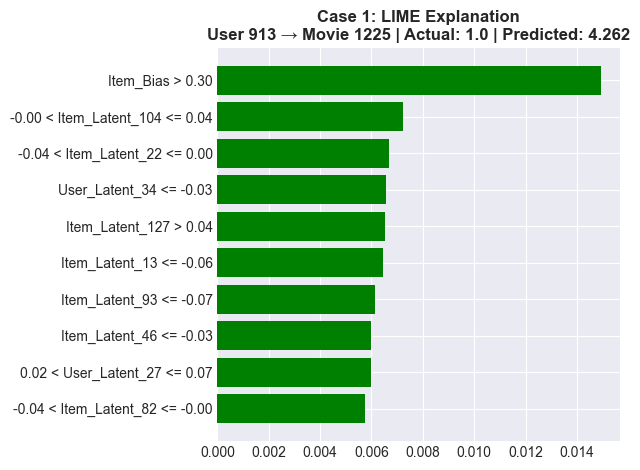


Top 10 Contributing Features:
Rank   Feature                   Weight       Impact    
----------------------------------------------------------------------
1      Item_Bias                 0.0149       Increases 
2      -0.00 < Item_Latent_104   0.0072       Increases 
3      -0.04 < Item_Latent_22    0.0067       Increases 
4      User_Latent_34            0.0066       Increases 
5      Item_Latent_127           0.0065       Increases 
6      Item_Latent_13            0.0064       Increases 
7      Item_Latent_93            0.0061       Increases 
8      Item_Latent_46            0.0060       Increases 
9      0.02 < User_Latent_27     0.0060       Increases 
10     -0.04 < Item_Latent_82    0.0058       Increases 





CASE 2: User 1266 → Movie 2881
Actual Rating: 1.0
Model Prediction: 3.345
Error: -2.345
LIME Prediction: 3.345


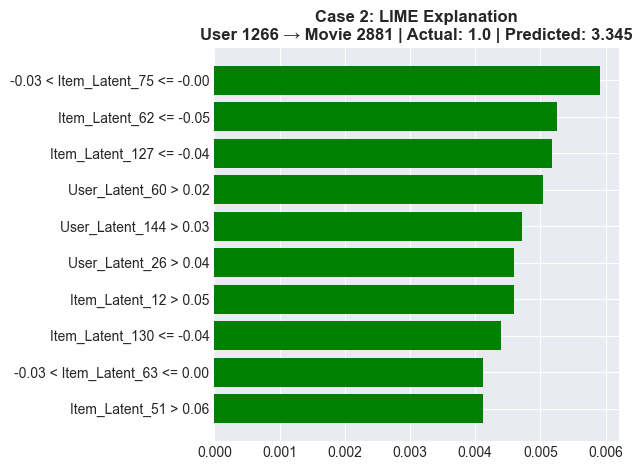


Top 10 Contributing Features:
Rank   Feature                   Weight       Impact    
----------------------------------------------------------------------
1      -0.03 < Item_Latent_75    0.0059       Increases 
2      Item_Latent_62            0.0052       Increases 
3      Item_Latent_127           0.0052       Increases 
4      User_Latent_60            0.0050       Increases 
5      User_Latent_144           0.0047       Increases 
6      User_Latent_26            0.0046       Increases 
7      Item_Latent_12            0.0046       Increases 
8      Item_Latent_130           0.0044       Increases 
9      -0.03 < Item_Latent_63    0.0041       Increases 
10     Item_Latent_51            0.0041       Increases 





CASE 3: User 3589 → Movie 2266
Actual Rating: 4.0
Model Prediction: 1.843
Error: 2.157
LIME Prediction: 1.843


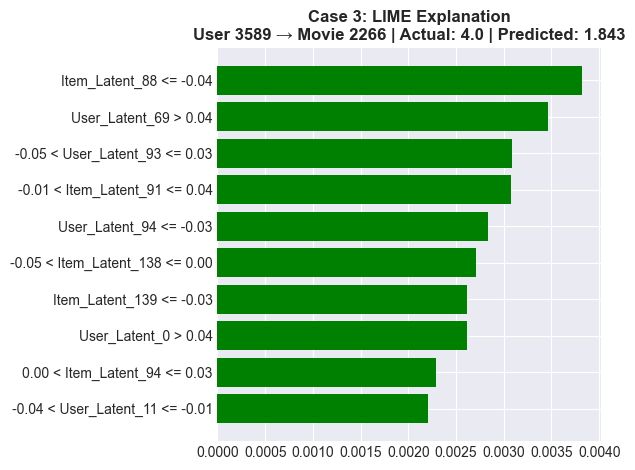


Top 10 Contributing Features:
Rank   Feature                   Weight       Impact    
----------------------------------------------------------------------
1      Item_Latent_88            0.0038       Increases 
2      User_Latent_69            0.0035       Increases 
3      -0.05 < User_Latent_93    0.0031       Increases 
4      -0.01 < Item_Latent_91    0.0031       Increases 
5      User_Latent_94            0.0028       Increases 
6      -0.05 < Item_Latent_138   0.0027       Increases 
7      Item_Latent_139           0.0026       Increases 
8      User_Latent_0             0.0026       Increases 
9      0.00 < Item_Latent_94     0.0023       Increases 
10     -0.04 < User_Latent_11    0.0022       Increases 





CASE 4: User 5387 → Movie 2294
Actual Rating: 5.0
Model Prediction: 2.944
Error: 2.056
LIME Prediction: 2.944


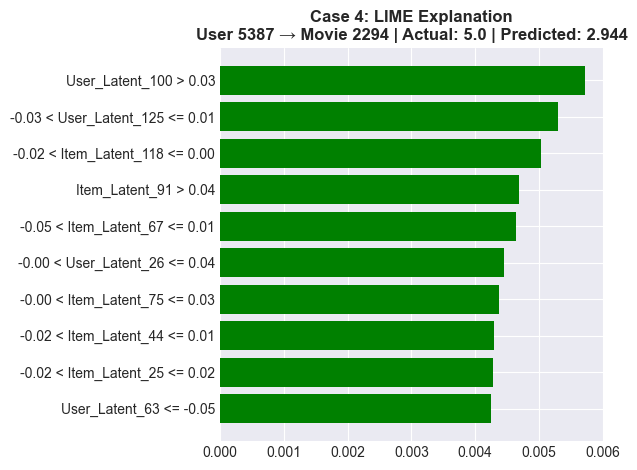


Top 10 Contributing Features:
Rank   Feature                   Weight       Impact    
----------------------------------------------------------------------
1      User_Latent_100           0.0057       Increases 
2      -0.03 < User_Latent_125   0.0053       Increases 
3      -0.02 < Item_Latent_118   0.0050       Increases 
4      Item_Latent_91            0.0047       Increases 
5      -0.05 < Item_Latent_67    0.0046       Increases 
6      -0.00 < User_Latent_26    0.0044       Increases 
7      -0.00 < Item_Latent_75    0.0044       Increases 
8      -0.02 < Item_Latent_44    0.0043       Increases 
9      -0.02 < Item_Latent_25    0.0043       Increases 
10     User_Latent_63            0.0042       Increases 





CASE 5: User 692 → Movie 593
Actual Rating: 4.0
Model Prediction: 4.991
Error: -0.991
LIME Prediction: 4.991


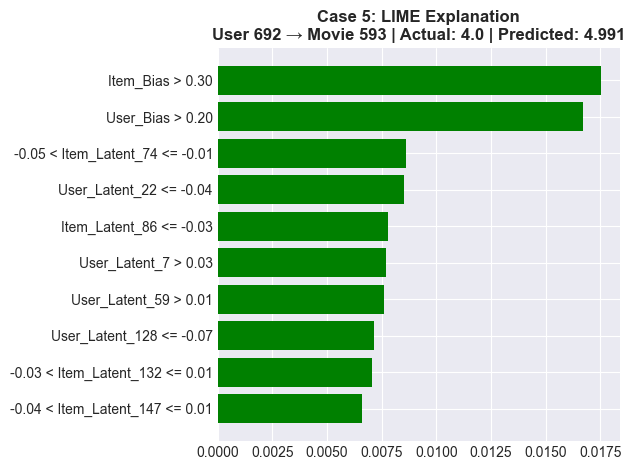


Top 10 Contributing Features:
Rank   Feature                   Weight       Impact    
----------------------------------------------------------------------
1      Item_Bias                 0.0175       Increases 
2      User_Bias                 0.0167       Increases 
3      -0.05 < Item_Latent_74    0.0086       Increases 
4      User_Latent_22            0.0085       Increases 
5      Item_Latent_86            0.0078       Increases 
6      User_Latent_7             0.0077       Increases 
7      User_Latent_59            0.0076       Increases 
8      User_Latent_128           0.0072       Increases 
9      -0.03 < Item_Latent_132   0.0071       Increases 
10     -0.04 < Item_Latent_147   0.0066       Increases 





CASE 6: User 4979 → Movie 2368
Actual Rating: 1.0
Model Prediction: 1.480
Error: -0.480
LIME Prediction: 1.480


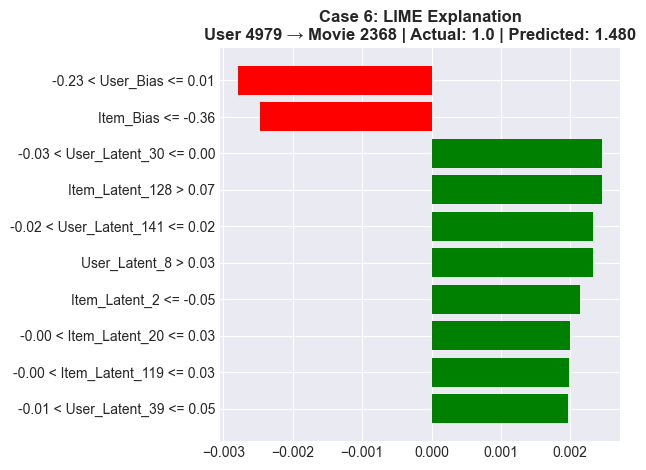


Top 10 Contributing Features:
Rank   Feature                   Weight       Impact    
----------------------------------------------------------------------
1      -0.23 < User_Bias         -0.0028      Decreases 
2      Item_Bias                 -0.0025      Decreases 
3      -0.03 < User_Latent_30    0.0025       Increases 
4      Item_Latent_128           0.0025       Increases 
5      -0.02 < User_Latent_141   0.0023       Increases 
6      User_Latent_8             0.0023       Increases 
7      Item_Latent_2             0.0021       Increases 
8      -0.00 < Item_Latent_20    0.0020       Increases 
9      -0.00 < Item_Latent_119   0.0020       Increases 
10     -0.01 < User_Latent_39    0.0020       Increases 





CASE 7: User 934 → Movie 3723
Actual Rating: 4.0
Model Prediction: 3.462
Error: 0.538
LIME Prediction: 3.462


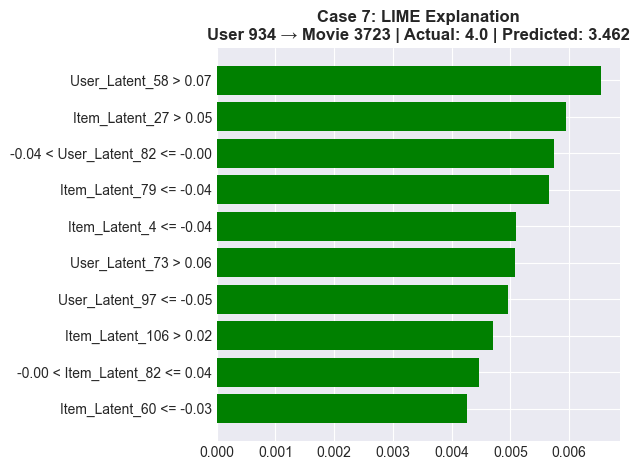


Top 10 Contributing Features:
Rank   Feature                   Weight       Impact    
----------------------------------------------------------------------
1      User_Latent_58            0.0065       Increases 
2      Item_Latent_27            0.0060       Increases 
3      -0.04 < User_Latent_82    0.0057       Increases 
4      Item_Latent_79            0.0057       Increases 
5      Item_Latent_4             0.0051       Increases 
6      User_Latent_73            0.0051       Increases 
7      User_Latent_97            0.0049       Increases 
8      Item_Latent_106           0.0047       Increases 
9      -0.00 < Item_Latent_82    0.0045       Increases 
10     Item_Latent_60            0.0043       Increases 



In [20]:
# Visualize each explanation
for i, (exp_obj, exp_data) in enumerate(zip(explanation_objects, explanations)):
    print("\n" + "=" * 70)
    print(f"CASE {exp_data['case_id']}: User {exp_data['user_id']} → Movie {exp_data['item_id']}")
    print("=" * 70)
    print(f"Actual Rating: {exp_data['actual_rating']:.1f}")
    print(f"Model Prediction: {exp_data['predicted_rating']:.3f}")
    print(f"Error: {exp_data['error']:.3f}")
    print(f"LIME Prediction: {exp_data['lime_prediction']:.3f}")
    
    # Show as matplotlib figure
    fig = exp_obj.as_pyplot_figure()
    plt.title(f"Case {exp_data['case_id']}: LIME Explanation\nUser {exp_data['user_id']} → Movie {exp_data['item_id']} | "
              f"Actual: {exp_data['actual_rating']:.1f} | Predicted: {exp_data['predicted_rating']:.3f}",
              fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print top features
    print("\nTop 10 Contributing Features:")
    print(f"{'Rank':<6} {'Feature':<25} {'Weight':<12} {'Impact':<10}")
    print("-" * 70)
    for rank, feature in enumerate(exp_data['top_features'], 1):
        impact = "Increases" if feature['weight'] > 0 else "Decreases"
        print(f"{rank:<6} {feature['feature']:<25} {feature['weight']:<12.4f} {impact:<10}")
    
    print("\n" + "=" * 70)
    
    # Add spacing between cases
    if i < len(explanations) - 1:
        print("\n\n")

### 8.2 Summary Visualization: Feature Importance Across All Cases

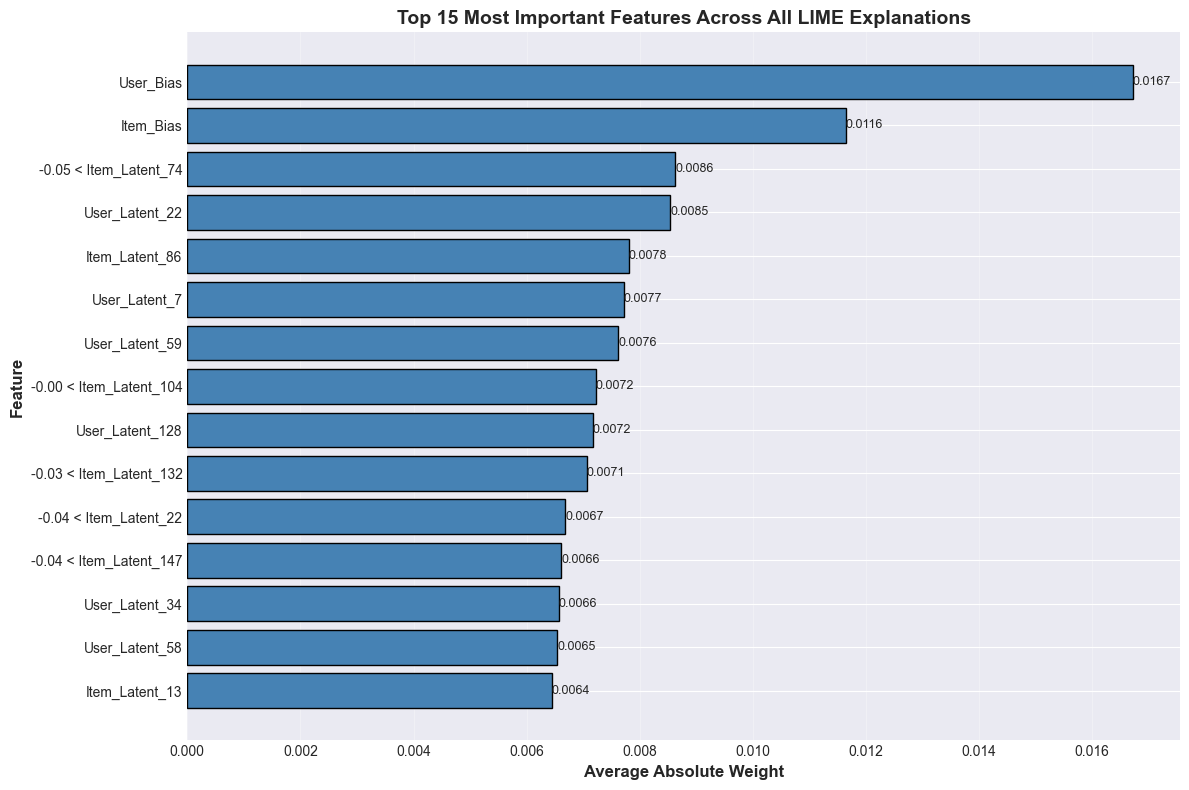


 Feature importance summary saved!


In [21]:
# Aggregate feature importance across all explanations
feature_importance_sum = {}
feature_importance_count = {}

for exp_data in explanations:
    for feature_info in exp_data['top_features']:
        feature_name = feature_info['feature']
        weight = abs(feature_info['weight'])  # Use absolute value for importance
        
        if feature_name not in feature_importance_sum:
            feature_importance_sum[feature_name] = 0
            feature_importance_count[feature_name] = 0
        
        feature_importance_sum[feature_name] += weight
        feature_importance_count[feature_name] += 1

# Calculate average importance
feature_importance_avg = {
    feature: feature_importance_sum[feature] / feature_importance_count[feature]
    for feature in feature_importance_sum
}

# Sort by importance
sorted_features = sorted(feature_importance_avg.items(), key=lambda x: x[1], reverse=True)[:15]

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
features = [f[0] for f in sorted_features]
importances = [f[1] for f in sorted_features]

bars = ax.barh(features, importances, color='steelblue', edgecolor='black')
ax.set_xlabel('Average Absolute Weight', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Most Important Features Across All LIME Explanations', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add value labels
for bar, importance in zip(bars, importances):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, 
            f'{importance:.4f}',
            ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(DATA_PATH + 'lime_feature_importance_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Feature importance summary saved!")

### 8.3 Heatmap: Feature Weights Across Cases

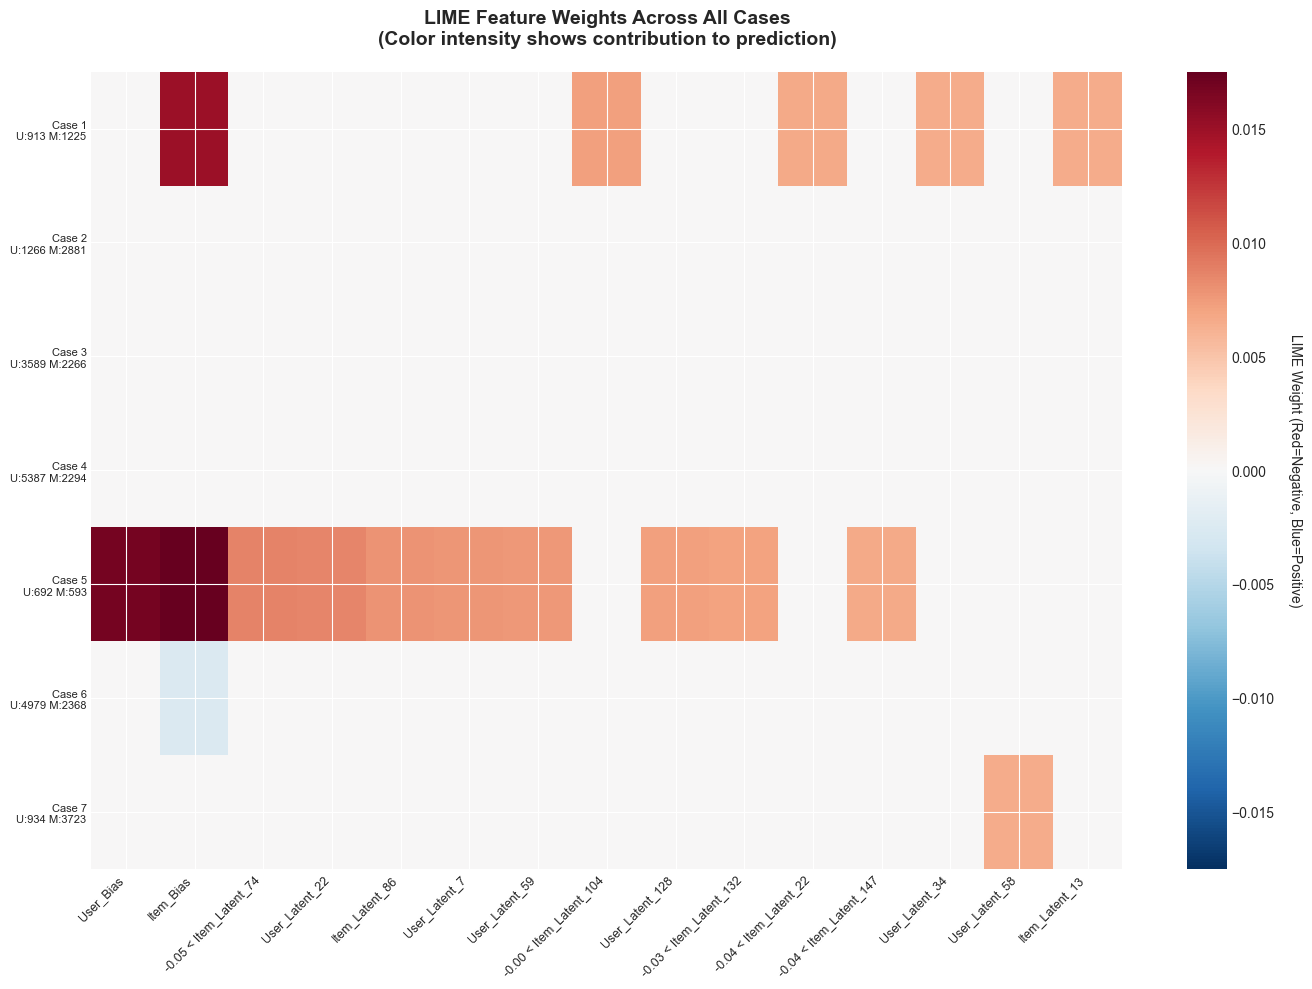


 Heatmap saved!


In [22]:
# Create a matrix of feature weights across cases
# Get top 15 most important features
top_features = [f[0] for f in sorted_features[:15]]

# Build matrix
weight_matrix = []
case_labels = []

for exp_data in explanations:
    case_labels.append(f"Case {exp_data['case_id']}\nU:{exp_data['user_id']} M:{exp_data['item_id']}")
    
    weights = []
    for feature in top_features:
        # Find weight for this feature
        weight = 0
        for feature_info in exp_data['top_features']:
            if feature_info['feature'] == feature:
                weight = feature_info['weight']
                break
        weights.append(weight)
    
    weight_matrix.append(weights)

# Plot heatmap
fig, ax = plt.subplots(figsize=(14, 10))
im = ax.imshow(weight_matrix, cmap='RdBu_r', aspect='auto', vmin=-max(abs(np.array(weight_matrix).flatten())), 
               vmax=max(abs(np.array(weight_matrix).flatten())))

# Set ticks
ax.set_xticks(np.arange(len(top_features)))
ax.set_yticks(np.arange(len(case_labels)))
ax.set_xticklabels(top_features, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(case_labels, fontsize=8)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('LIME Weight (Red=Negative, Blue=Positive)', rotation=270, labelpad=20, fontsize=10)

# Title
ax.set_title('LIME Feature Weights Across All Cases\n(Color intensity shows contribution to prediction)',
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(DATA_PATH + 'lime_weight_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Heatmap saved!")

## 9. Save LIME Explanations

### 9.1 Save Detailed Explanations as JSON

In [23]:
# Save all explanations to JSON
explanations_json_path = DATA_PATH + 'lime_explanations.json'

with open(explanations_json_path, 'w') as f:
    json.dump(explanations, f, indent=2)

print(f" Detailed explanations saved to: {explanations_json_path}")
print(f"   Number of explanations: {len(explanations)}")
print(f"   File size: {len(json.dumps(explanations)) / 1024:.2f} KB")

 Detailed explanations saved to: ../data/processed/lime_explanations.json
   Number of explanations: 7
   File size: 9.41 KB


### 9.2 Save Explanations as CSV for Easy Analysis

In [24]:
# Create flattened CSV with top features
explanations_flat = []

for exp_data in explanations:
    row = {
        'case_id': exp_data['case_id'],
        'user_id': exp_data['user_id'],
        'item_id': exp_data['item_id'],
        'actual_rating': exp_data['actual_rating'],
        'predicted_rating': exp_data['predicted_rating'],
        'error': exp_data['error'],
        'absolute_error': exp_data['absolute_error'],
        'lime_prediction': exp_data['lime_prediction']
    }
    
    # Add top 5 features
    for i, feature_info in enumerate(exp_data['top_features'][:5], 1):
        row[f'top{i}_feature'] = feature_info['feature']
        row[f'top{i}_weight'] = feature_info['weight']
    
    explanations_flat.append(row)

explanations_df = pd.DataFrame(explanations_flat)
explanations_csv_path = DATA_PATH + 'lime_explanations.csv'
explanations_df.to_csv(explanations_csv_path, index=False)

print(f"\n Explanations CSV saved to: {explanations_csv_path}")
print(f"\nPreview:")
display(explanations_df)


 Explanations CSV saved to: ../data/processed/lime_explanations.csv

Preview:


,case_id,user_id,item_id,actual_rating,predicted_rating,error,absolute_error,lime_prediction,top1_feature,top1_weight,top2_feature,top2_weight,top3_feature,top3_weight,top4_feature,top4_weight,top5_feature,top5_weight
0,1,913,1225,1.0,4.262491,-3.262491,3.262491,4.262491,Item_Bias,0.014935,-0.00 < Item_Latent_104,0.007219,-0.04 < Item_Latent_22,0.006684,User_Latent_34,0.006563,Item_Latent_127,0.006519
1,2,1266,2881,1.0,3.344708,-2.344708,2.344708,3.344708,-0.03 < Item_Latent_75,0.005911,Item_Latent_62,0.005247,Item_Latent_127,0.005181,User_Latent_60,0.005040,User_Latent_144,0.004715
2,3,3589,2266,4.0,1.843342,2.156658,2.156658,1.843342,Item_Latent_88,0.003824,User_Latent_69,0.003462,-0.05 < User_Latent_93,0.003090,-0.01 < Item_Latent_91,0.003080,User_Latent_94,0.002838
3,4,5387,2294,5.0,2.943691,2.056309,2.056309,2.943691,User_Latent_100,0.005723,-0.03 < User_Latent_125,0.005300,-0.02 < Item_Latent_118,0.005028,Item_Latent_91,0.004684,-0.05 < Item_Latent_67,0.004634
4,5,692,593,4.0,4.990834,-0.990834,0.990834,4.990834,Item_Bias,0.017522,User_Bias,0.016716,-0.05 < Item_Latent_74,0.008632,User_Latent_22,0.008536,Item_Latent_86,0.007803
5,6,4979,2368,1.0,1.480144,-0.480144,0.480144,1.480144,-0.23 < User_Bias,-0.002787,Item_Bias,-0.002479,-0.03 < User_Latent_30,0.002455,Item_Latent_128,0.002454,-0.02 < User_Latent_141,0.002331
6,7,934,3723,4.0,3.462255,0.537745,0.537745,3.462255,User_Latent_58,0.006538,Item_Latent_27,0.005952,-0.04 < User_Latent_82,0.005748,Item_Latent_79,0.005651,Item_Latent_4,0.005087


### 9.3 Create Summary Report

In [ ]:
# Create comprehensive summary
lime_summary = {
    'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_info': {
        'model_type': model_metadata['model_type'],
        'model_rmse': model_metadata['performance']['rmse'],
        'model_mae': model_metadata['performance']['mae']
    },
    'lime_config': {
        'num_cases_explained': len(explanations),
        'num_features': len(feature_cols),
        'top_features_per_explanation': 10,
        'num_samples_per_explanation': 5000
    },
    'explanation_statistics': {
        'avg_absolute_error': float(np.mean([e['absolute_error'] for e in explanations])),
        'max_absolute_error': float(np.max([e['absolute_error'] for e in explanations])),
        'avg_lime_prediction': float(np.mean([e['lime_prediction'] for e in explanations])),
        'avg_model_prediction': float(np.mean([e['predicted_rating'] for e in explanations]))
    },
    'most_important_features': [
        {'feature': f[0], 'avg_importance': f[1]}
        for f in sorted_features[:10]
    ],
    'output_files': {
        'lime_explanations_json': explanations_json_path,
        'lime_explanations_csv': explanations_csv_path,
        'feature_importance_plot': DATA_PATH + 'lime_feature_importance_summary.png',
        'weight_heatmap': DATA_PATH + 'lime_weight_heatmap.png'
    }
}

summary_path = DATA_PATH + 'lime_summary.json'
with open(summary_path, 'w') as f:
    json.dump(lime_summary, f, indent=2)

print("\n" + "=" * 70)
print("LIME ANALYSIS SUMMARY")
print("=" * 70)
print(json.dumps(lime_summary, indent=2))
print("\n Summary saved to:", summary_path)
print("=" * 70)


LIME ANALYSIS SUMMARY
{
  "creation_date": "2025-11-11 20:53:17",
  "model_info": {
    "model_type": "SVD",
    "model_rmse": 0.9360922389641702,
    "model_mae": 0.7432639251679765
  },
  "lime_config": {
    "num_cases_explained": 7,
    "num_features": 303,
    "top_features_per_explanation": 10,
    "num_samples_per_explanation": 5000
  },
  "explanation_statistics": {
    "avg_absolute_error": 1.6898412889917276,
    "max_absolute_error": 3.262490739749621,
    "avg_lime_prediction": 3.1896376995880975,
    "avg_model_prediction": 3.189637699588097
  },
  "most_important_features": [
    {
      "feature": "User_Bias",
      "avg_importance": 0.016716305374233752
    },
    {
      "feature": "Item_Bias",
      "avg_importance": 0.011645203822998239
    },
    {
      "feature": "-0.05 < Item_Latent_74",
      "avg_importance": 0.008632005858353812
    },
    {
      "feature": "User_Latent_22",
      "avg_importance": 0.008536345009929495
    },
    {
      "feature": "Item_Lat

## 10. Interpret LIME Results

In [26]:
print("\n" + "=" * 70)
print("KEY INSIGHTS FROM LIME EXPLANATIONS")
print("=" * 70)

# Insight 1: Most influential features
print("\n1. MOST INFLUENTIAL FEATURES ACROSS ALL CASES:")
print("-" * 70)
for i, (feature, importance) in enumerate(sorted_features[:5], 1):
    print(f"   {i}. {feature}: {importance:.4f}")

# Insight 2: Bias vs Latent factors
bias_features = [f for f in sorted_features if 'Bias' in f[0]]
latent_features = [f for f in sorted_features if 'Latent' in f[0]]

print("\n2. CONTRIBUTION COMPARISON:")
print("-" * 70)
if bias_features:
    avg_bias_importance = np.mean([f[1] for f in bias_features])
    print(f"   Average Bias importance: {avg_bias_importance:.4f}")
if latent_features:
    avg_latent_importance = np.mean([f[1] for f in latent_features])
    print(f"   Average Latent factor importance: {avg_latent_importance:.4f}")

# Insight 3: Prediction accuracy
print("\n3. LIME PREDICTION ACCURACY:")
print("-" * 70)
lime_preds = [e['lime_prediction'] for e in explanations]
model_preds = [e['predicted_rating'] for e in explanations]
lime_model_diff = np.mean([abs(l - m) for l, m in zip(lime_preds, model_preds)])
print(f"   Average difference between LIME and Model predictions: {lime_model_diff:.4f}")
print(f"   (Lower is better - indicates LIME is accurately approximating the model)")

# Insight 4: Error patterns
print("\n4. ERROR PATTERNS:")
print("-" * 70)
over_pred = [e for e in explanations if e['error'] < 0]
under_pred = [e for e in explanations if e['error'] > 0]
print(f"   Cases with over-prediction (predicted > actual): {len(over_pred)}")
print(f"   Cases with under-prediction (predicted < actual): {len(under_pred)}")

print("\n5. INTERPRETATION GUIDELINES:")
print("-" * 70)
print("""
   - Positive weights: Feature increases the predicted rating
   - Negative weights: Feature decreases the predicted rating
   - Larger absolute weights: More influential features
   
   User/Item Biases: 
     - User bias: This user tends to rate higher/lower than average
     - Item bias: This movie tends to be rated higher/lower than average
   
   Latent Factors:
     - Represent hidden preferences/characteristics
     - Interaction between user and item latent factors drives prediction
     - High positive weight: Strong alignment between user preference and item characteristic
""")

print("=" * 70)


KEY INSIGHTS FROM LIME EXPLANATIONS

1. MOST INFLUENTIAL FEATURES ACROSS ALL CASES:
----------------------------------------------------------------------
   1. User_Bias: 0.0167
   2. Item_Bias: 0.0116
   3. -0.05 < Item_Latent_74: 0.0086
   4. User_Latent_22: 0.0085
   5. Item_Latent_86: 0.0078

2. CONTRIBUTION COMPARISON:
----------------------------------------------------------------------
   Average Bias importance: 0.0142
   Average Latent factor importance: 0.0073

3. LIME PREDICTION ACCURACY:
----------------------------------------------------------------------
   Average difference between LIME and Model predictions: 0.0000
   (Lower is better - indicates LIME is accurately approximating the model)

4. ERROR PATTERNS:
----------------------------------------------------------------------
   Cases with over-prediction (predicted > actual): 4
   Cases with under-prediction (predicted < actual): 3

5. INTERPRETATION GUIDELINES:
-------------------------------------------------